If you cannot explain a tensor’s shape, you do not understand the code.

In [2]:
from PIL import Image
from collections import Counter
import inspect
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import binary_fill_holes
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as T

In [6]:
print(inspect.getsource(nn.Module))

class Module:
    r"""Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self) -> None:
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this modu

In [7]:
class ConvBlock(nn.Module):     # ConvBlock inherits from nn.Module

    """
    The block consists of two consecutive 3x3 convolution layers, each followed by a ReLU activation.
    """

    def __init__(self, in_channels, out_channels):

        # The constructor calls nn.Module.__init__() to initialize internal containers for parameters and submodules
        super().__init__()

        # self.conv stores a nn.Sequential object that groups multiple layers
        self.conv = nn.Sequential(                                              # conv is a user-defined name registered as a submodule
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),     # Applies a 3x3 convolution, maps in_channels to out_channels, and preserves spatial dimensions
            nn.ReLU(inplace=True),                                              # Applies ReLU non-linearity, inplace=True saves memory by modifying the tensor directly
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):     # The forward method passes the input through the Conv -> ReLU -> Conv -> ReLU sequence
        return self.conv(x)

In [8]:
# Output size = floor((input size - kernel size + 2 x padding) / stride) + 1
# This formula applies separately to height and width

block = ConvBlock(in_channels=3, out_channels=64)     # The block uses 64 randomly initialized 3×3 convolution kernels
x = torch.randn(1, 3, 128, 128)     # Create a dummy input tensor: (batch_size, channels, height, width)
y = block(x)

print("Input shape:", x.shape)
print("Output shape:", y.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 64, 128, 128])


In [9]:
class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.conv_block = ConvBlock(in_channels, out_channels)     # The convolution block extracts local features while preserving spatial dimensions
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)          # Max pooling reduces the spatial resolution by a factor of 2

    def forward(self, x):     # The forward method passes the input through the Conv -> MaxPool sequence
        x_conved = self.conv_block(x)   # Feature extraction for skip connections
        x_pooled = self.pool(x_conved)  # Downsampling

        return x_conved, x_pooled

In [10]:
x = torch.randn(1, 1, 256, 256)
down = DownBlock(in_channels=1, out_channels=64)
conved, pooled = down(x)

print("Input shape:", x.shape)
print("Shape after convolution:", conved.shape)
print("Shape after max-pooling:", pooled.shape)

Input shape: torch.Size([1, 1, 256, 256])
Shape after convolution: torch.Size([1, 64, 256, 256])
Shape after max-pooling: torch.Size([1, 64, 128, 128])


In [11]:
class UpBlock(nn.Module):

    def __init__(self, in_channels, skip_channels, out_channels):

        super().__init__()

        # Transposed convolution for upsampling:
        # - Doubles spatial resolution (H, W)
        # - Reduces channel depth from in_channels → out_channels
        # Output size formula: (input_size - 1) * stride - 2 * padding + kernel_size + output_padding
        self.up = nn.ConvTranspose2d(    
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2
        )

        self.conv_block = ConvBlock(
            in_channels=out_channels + skip_channels,     # Channels after concat = out_channels (upsampled) + skip_channels (encoder feature)
            out_channels=out_channels
        )

    def forward(self, x, skip):  
        # x_up.shape[-2:] == skip.shape[-2:] (Spatial dimensions must match before concatenation)

        # Upsample decoder feature map
        x_up = self.up(x)              # Shape: (B, out_channels, H, W)

        # Concatenate skip connection and upsampled feature map along channel dimension
        x_cat = torch.cat([skip, x_up], dim=1)  # Shape: (B, out_channels + skip_channels, H, W)

        out = self.conv_block(x_cat)     # Fuse features using convolutional block
        return out

In [12]:
x = torch.randn(1, 128, 128, 128)     
skip = torch.randn(1, 64, 256, 256)  

up = UpBlock(
    in_channels=128,
    skip_channels=64,
    out_channels=64
)

y = up(x, skip)

print("Decoder input:", x.shape)
print("Skip input:", skip.shape)
print("Output shape:", y.shape)

Decoder input: torch.Size([1, 128, 128, 128])
Skip input: torch.Size([1, 64, 256, 256])
Output shape: torch.Size([1, 64, 256, 256])


In [13]:
class UNet(nn.Module):

    def __init__(self):

        super().__init__()

        # Encoder
        self.down1 = DownBlock(1, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder
        self.up4 = UpBlock(1024, 512, 512)
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 64)

        # Output
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Encoder
        skip1, x = self.down1(x)
        skip2, x = self.down2(x)
        skip3, x = self.down3(x)
        skip4, x = self.down4(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)

        # Output
        x = self.out_conv(x)
        # x = self.sigmoid(x)

        return x

In [ ]:
x = torch.randn(1, 1, 800, 544)     # (batch size, channels, height, width)

model = UNet()     # Instantiate the U-Net model

with torch.no_grad():
    y = model(x)

print("Input shape:", x.shape)
print("Output shape:", y.shape)

Input: torch.Size([1, 1, 800, 544])
Down1: torch.Size([1, 64, 800, 544]) torch.Size([1, 64, 400, 272])
Down2: torch.Size([1, 128, 400, 272]) torch.Size([1, 128, 200, 136])
Down3: torch.Size([1, 256, 200, 136]) torch.Size([1, 256, 100, 68])
Down4: torch.Size([1, 512, 100, 68]) torch.Size([1, 512, 50, 34])
Bottleneck: torch.Size([1, 1024, 50, 34])
Up4: torch.Size([1, 512, 100, 68])
Up3: torch.Size([1, 256, 200, 136])
Up2: torch.Size([1, 128, 400, 272])
Up1: torch.Size([1, 64, 800, 544])
Output: torch.Size([1, 1, 800, 544])
Input shape: torch.Size([1, 1, 800, 544])
Output shape: torch.Size([1, 1, 800, 544])


In [ ]:
dataset_dirs = {
    "Train": "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/train/masks",
    "Test":  "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/test/masks",
    "Valid": "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/valid/masks",
}

for split_name, mask_dir in dataset_dirs.items():
    print(f"\nProcessing {split_name} masks")

    if not os.path.isdir(mask_dir):
        print(f"Skipped (directory not found): {mask_dir}")
        continue

    filled_mask_dir = os.path.join(
        os.path.dirname(mask_dir),  
        "filled_masks"
    )
    os.makedirs(filled_mask_dir, exist_ok=True)

    mask_files = sorted([
        f for f in os.listdir(mask_dir)
        if f.lower().endswith(".png")
    ])

    print(f"Found {len(mask_files)} mask files")

    for fname in mask_files:
        
        in_path  = os.path.join(mask_dir, fname)
        out_path = os.path.join(filled_mask_dir, fname)

        mask = Image.open(in_path).convert("L")
        mask_np = np.array(mask)

        mask_bin = mask_np > 127

        mask_filled = binary_fill_holes(mask_bin)

        mask_filled = (mask_filled.astype(np.uint8)) * 255

        Image.fromarray(mask_filled).save(out_path)

    print(f"Saved filled masks")

print("\nDatasets processed successfully.")


Processing Train masks
Found 799 mask files
Saved filled masks

Processing Test masks
Found 101 mask files
Saved filled masks

Processing Valid masks
Found 99 mask files
Saved filled masks

Datasets processed successfully.


In [54]:
# Sanity check

dataset_dirs = {
    "Train (imgs)": "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/train/images",
    "Train (masks)": "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/train/filled_masks",
    "Test (imgs)":  "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/test/images",
    "Test (masks)":  "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/test/filled_masks",
    "Valid (imgs)": "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/valid/images",
    "Valid (masks)": "/Users/sasha/Documents/fetal-tumor-segmentation/data/dataset/valid/filled_masks",
}

for split_name, folder in dataset_dirs.items():
    image_sizes = []

    for filename in os.listdir(folder):
        if filename.lower().endswith(".png"):
            file_path = os.path.join(folder, filename)
            with Image.open(file_path) as image:
                image_sizes.append(image.size)

    size_frequency = Counter(image_sizes)

    print(f"{split_name} set -> {size_frequency}")

Train (imgs) set -> Counter({(800, 544): 799})
Train (masks) set -> Counter({(800, 544): 799})
Test (imgs) set -> Counter({(800, 544): 101})
Test (masks) set -> Counter({(800, 544): 101})
Valid (imgs) set -> Counter({(800, 544): 99})
Valid (masks) set -> Counter({(800, 544): 99})


In [55]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


Found 1 images

Overfitting on: 4_HC.png
Foreground ratio: 0.10555606335401535
Epoch 000 | Total: 1.0735 | Dice: 0.8252 | BCE: 1.2413 | logits[min, max, std deviation]=(0.0140, 0.0499, 0.0038)
Epoch 010 | Total: 1.0692 | Dice: 0.8228 | BCE: 1.2319 | logits[min, max, std deviation]=(0.0415, 0.1796, 0.0236)
Epoch 020 | Total: 1.0604 | Dice: 0.8183 | BCE: 1.2107 | logits[min, max, std deviation]=(0.0369, 0.4670, 0.0830)
Epoch 030 | Total: 1.0336 | Dice: 0.8027 | BCE: 1.1546 | logits[min, max, std deviation]=(-0.0363, 1.5744, 0.3022)
Epoch 040 | Total: 0.9722 | Dice: 0.7551 | BCE: 1.0855 | logits[min, max, std deviation]=(-0.5051, 5.0342, 1.1088)
Epoch 050 | Total: 0.8197 | Dice: 0.6507 | BCE: 0.8450 | logits[min, max, std deviation]=(-83.9223, 4.8859, 30.9671)
Epoch 060 | Total: 0.7544 | Dice: 0.5795 | BCE: 0.8748 | logits[min, max, std deviation]=(-14.8303, 6.6230, 6.1294)
Epoch 070 | Total: 0.6691 | Dice: 0.5260 | BCE: 0.7156 | logits[min, max, std deviation]=(-28.8231, 4.4758, 12.4007)

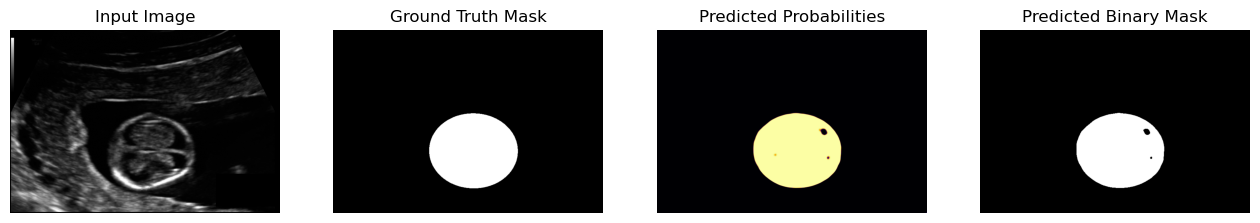

In [17]:
over_root = "/Users/sasha/Documents/fetal-tumor-segmentation/data/overfit"

over_img  = os.path.join(over_root, "images")
over_mask = os.path.join(over_root, "filled_masks")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
epochs = 300
lr = 1e-4

def load_grayscale(path):
    return np.array(Image.open(path).convert("L"))

def normalize_image(img):
    return img.astype(np.float32) / 255.0

def binarize_mask(mask):
    return (mask > 0).astype(np.uint8)

def to_tensor(arr):
    return torch.tensor(arr).unsqueeze(0).unsqueeze(0)

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum()
    den = probs.sum() + targets.sum() + eps
    return 1 - num / den

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

image_files = sorted(f for f in os.listdir(over_img) if f.endswith(".png"))
print(f"Found {len(image_files)} images")

fname = image_files[0]
print(f"\nOverfitting on: {fname}")

img_path  = os.path.join(over_img, fname)
mask_path = os.path.join(over_mask, fname.replace(".png", "_Annotation.png"))

img  = normalize_image(load_grayscale(img_path))
mask = binarize_mask(load_grayscale(mask_path))

img  = to_tensor(img).float().to(device)
mask = to_tensor(mask).float().to(device)

fg_ratio = mask.mean().item()
print("Foreground ratio:", fg_ratio)

pos_weight = torch.tensor([(1 - fg_ratio) / fg_ratio]).to(device)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()

    logits = model(img)

    loss_dice = dice_loss(logits, mask)
    loss_bce  = bce(logits, mask)

    # Dice leads, BCE stabilizes
    loss = loss_dice + 0.2 * loss_bce

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Total: {loss.item():.4f} | "
            f"Dice: {loss_dice.item():.4f} | "
            f"BCE: {loss_bce.item():.4f} | "
            f"logits[min, max, std deviation]=("
            f"{logits.min().item():.4f}, "
            f"{logits.max().item():.4f}, "
            f"{logits.std().item():.4f})"
        )

model.eval()
with torch.no_grad():
    probs  = torch.sigmoid(model(img))
    binary = (probs > 0.5).float()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].set_title("Input Image")
axes[0].imshow(img[0,0].cpu(), cmap="gray")
axes[0].axis("off")

axes[1].set_title("Ground Truth Mask")
axes[1].imshow(mask[0,0].cpu(), cmap="gray")
axes[1].axis("off")

axes[2].set_title("Predicted Probabilities")
axes[2].imshow(probs[0,0].cpu(), cmap="inferno")
axes[2].axis("off")

axes[3].set_title("Predicted Binary Mask")
axes[3].imshow(binary[0,0].cpu(), cmap="gray")
axes[3].axis("off")

plt.show()